In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib.animation import FuncAnimation
#from matplotlib import animation, rc


In [2]:

xmin = -1
xmax = 1
Ngrid = 1000

dx = (xmax-xmin)/(Ngrid-1)
dp = 2*np.pi/(dx*Ngrid)
dt = 10

xx = np.linspace(xmin,xmax,Ngrid)
zz = np.linspace(xmin,xmax,Ngrid)
px = np.fft.fftfreq(Ngrid)*dp
pz = np.fft.fftfreq(Ngrid)*dp

def gauss2d(x,z,mu_x,mu_z,sigma):
    factor = 1/(np.sqrt(np.pi)*sigma)
    exponent = -0.5*((x-mu_x)**2 + (z-mu_z)**2)/sigma**2
    return factor * np.exp(exponent)

def plane_wave(x,kx):
    return np.exp(1j* kx * x)

c_pm = np.array([1/np.sqrt(2),1/np.sqrt(2)])
mu_x = 0
mu_z = 0
sigma = 0.05
psi0 = np.zeros((2,Ngrid,Ngrid), dtype=complex)
for s in range(2):
    for i in range(Ngrid):
        for j in range(Ngrid):
            psi0[s][i][j] = c_pm[s]*gauss2d(xx[i],zz[j],mu_x,mu_z,sigma)

'''
fig, ax = plt.subplots()
plt.pcolormesh(xx,zz, np.abs(psi0[0])**2 )
cbar = plt.colorbar()

psi0_p = np.array( [ np.fft.fftn(psi0[0]) , np.fft.fftn(psi0[1]) ] ) 
fig, ax = plt.subplots()
plt.pcolormesh(np.sort(px),np.sort(pz),np.abs(np.fft.fftshift(psi0_p[0])))
cbar = plt.colorbar()

fig, ax = plt.subplots()
plt.pcolormesh(xx,zz, np.abs(np.fft.ifftn(psi0_p[0]))**2 )
cbar = plt.colorbar()

fig, ax = plt.subplots()
plt.scatter(zz,psi0[0].T[50])
'''


'\nfig, ax = plt.subplots()\nplt.pcolormesh(xx,zz, np.abs(psi0[0])**2 )\ncbar = plt.colorbar()\n\npsi0_p = np.array( [ np.fft.fftn(psi0[0]) , np.fft.fftn(psi0[1]) ] ) \nfig, ax = plt.subplots()\nplt.pcolormesh(np.sort(px),np.sort(pz),np.abs(np.fft.fftshift(psi0_p[0])))\ncbar = plt.colorbar()\n\nfig, ax = plt.subplots()\nplt.pcolormesh(xx,zz, np.abs(np.fft.ifftn(psi0_p[0]))**2 )\ncbar = plt.colorbar()\n\nfig, ax = plt.subplots()\nplt.scatter(zz,psi0[0].T[50])\n'

In [3]:
gamma = 0.5
beta = 0.01
B0 = 1

T = np.zeros((2,Ngrid,Ngrid), dtype=complex)
expT = np.zeros((2,Ngrid,Ngrid), dtype=complex)
def kinetic(px,pz,m):
    return (px**2 + pz**2)/(2*m)

expV_diag = np.zeros((2,Ngrid,Ngrid), dtype=complex)
expV_offdiag = np.zeros((Ngrid,Ngrid), dtype=complex)
def root(x,z): return np.sqrt(beta**2 * x**2 + (beta*z+B0)**2 )
def cosine(x,z): return np.cos(gamma*dt*root(x,z)/4.0)
def sine(x,z): return np.sin(gamma*dt*root(x,z)/4.0)
def Bx_norm(x,z): return -beta*x/root(x,z)
def Bz_norm(x,z): return (beta*z+B0)/root(x,z)
    
for i in range(Ngrid):
    for j in range(Ngrid):
        T[0][i][j] = kinetic(px[i],pz[j],1)
        expT[0][i][j] = np.exp(-1j*dt*T[0][i][j])
        T[1][i][j] = kinetic(px[i],pz[j],1)
        expT[1][i][j] = np.exp(-1j*dt*T[1][i][j])
        
        expV_diag[0][i][j] = cosine(xx[i],zz[j]) + 1j*Bz_norm(xx[i],zz[j])*sine(xx[i],zz[j])
        expV_diag[1][i][j] = cosine(xx[i],zz[j]) - 1j*Bz_norm(xx[i],zz[j])*sine(xx[i],zz[j]) 
        expV_offdiag[i][j] = 1j*Bx_norm(xx[i],zz[j])*sine(xx[i],zz[j]) 


def trotter_step(psi_in,expT,expV_diag,expV_offdiag):
        psi_out = psi_in.copy()
        
        # Aplicar potencial
        psi_out[0] = expV_diag[0]*psi_out[0] + expV_offdiag*psi_out[1]
        psi_out[1] = expV_diag[1]*psi_out[1] + expV_offdiag*psi_out[0]
        
        # Fourier
        psi_p_up = np.fft.fftn(psi_out[0])
        psi_p_down = np.fft.fftn(psi_out[1])
        
        # Aplicar término cinético
        psi_p_up *= expT[0]
        psi_p_down *= expT[1]
        
        # Fourier inverso
        psi_out[0] = np.fft.ifftn(psi_p_up)
        psi_out[1] = np.fft.ifftn(psi_p_down)
        
        # Aplicar potencial
        psi_out[0] = expV_diag[0]*psi_out[0] + expV_offdiag*psi_out[1]
        psi_out[1] = expV_diag[1]*psi_out[1] + expV_offdiag*psi_out[0]
        
        # Este paso sobra en nuestra implementación
        #psi_p = np.fft.fftn(psi)
        return psi_out


In [4]:
Nsteps = 1000
psi = psi0
for t in range(Nsteps):
    psi = trotter_step(psi,expT,expV_diag,expV_offdiag)


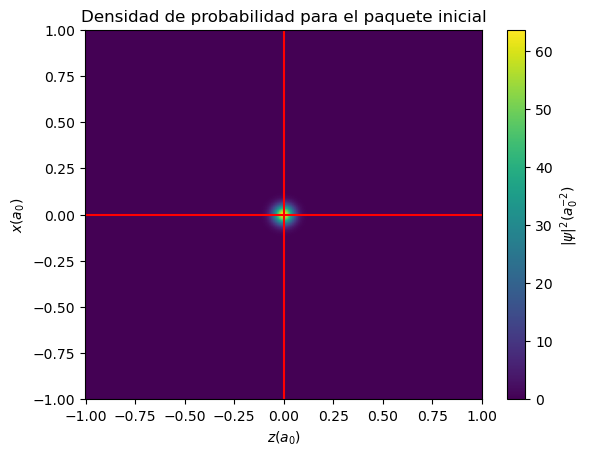

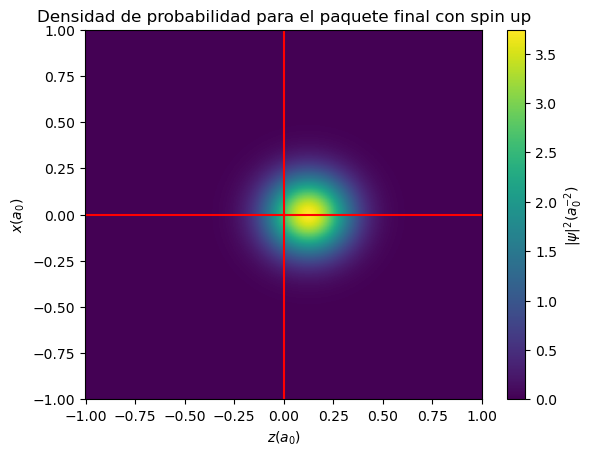

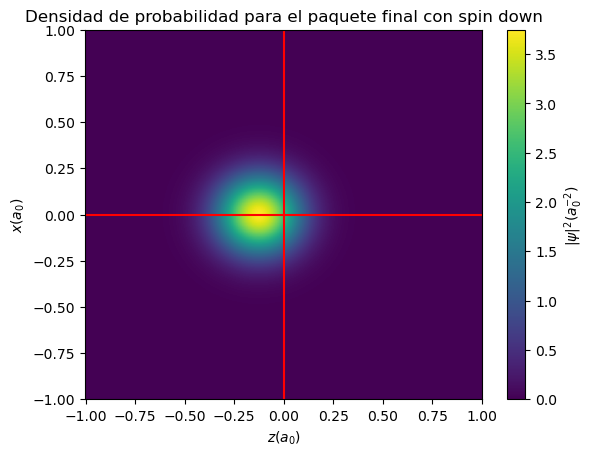

In [5]:
fig, ax = plt.subplots()
plt.pcolormesh(xx,zz, np.abs(psi0[0])**2 )
plt.plot([-1,1],[0,0],color='r')
plt.plot([0,0],[-1,1],color='r')
cbar = plt.colorbar()
ax.set_xlabel(r'$z(a_0)$')
ax.set_ylabel(r'$x(a_0)$')
cbar.set_label(r'$|\psi|^2 (a_0^{-2})$')
ax.set_title('Densidad de probabilidad para el paquete inicial')
plt.savefig('initial.png')


fig, ax = plt.subplots()
plt.pcolormesh(xx,zz, np.abs(psi[0])**2 )
plt.plot([-1,1],[0,0],color='r')
plt.plot([0,0],[-1,1],color='r')
cbar = plt.colorbar()
ax.set_xlabel(r'$z(a_0)$')
ax.set_ylabel(r'$x(a_0)$')
cbar.set_label(r'$|\psi|^2 (a_0^{-2})$')
ax.set_title('Densidad de probabilidad para el paquete final con spin up')
plt.savefig('final-up.png')

fig, ax = plt.subplots()
plt.pcolormesh(xx,zz, np.abs(psi[1])**2 )
plt.plot([-1,1],[0,0],color='r')
plt.plot([0,0],[-1,1],color='r')
cbar = plt.colorbar()
ax.set_xlabel(r'$z(a_0)$')
ax.set_ylabel(r'$x(a_0)$')
cbar.set_label(r'$|\psi|^2 (a_0^{-2})$')
ax.set_title('Densidad de probabilidad para el paquete final con spin down')
plt.savefig('final-down.png')
